In [481]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from IPython.display import display
from deep_translator import GoogleTranslator



In [482]:
#Cargar y preparar los datos
try:
    df = pd.read_csv("McDonald.csv", encoding='latin1')
except FileNotFoundError:
    print("Error: El archivo 'McDonalds_Reviews.csv' no se encuentra.")
    print("Por favor, asegúrate de que el archivo está en el mismo directorio.")
    exit()


In [483]:
#imprimir
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [484]:
#verificar columnas
df.columns

Index(['reviewer_id', 'store_name', 'category', 'store_address', 'latitude ',
       'longitude', 'rating_count', 'review_time', 'review', 'rating'],
      dtype='object')

In [485]:
# Crear un DataFrame de ejemplo
#data = {'review': ['Buen servicio y comida deliciosa.', 'La comida estaba fría y el lugar sucio.',
                   #'Me encantan sus papas fritas.', 'El personal es lento, mala experiencia.',
                   #'Todo perfecto, volveré pronto.', 'Nunca más volveré, horrible lugar.',
                   #'El café estaba bien, pero la fila era muy larga.', 'Me gustó el ambiente.',
                   #'El servicio es lento.', 'Una experiencia terrible.', 'Muy buen restaurante.'],
        #'rating': [5, 1, 5, 2, 4, 1, 3, 4, 2, 1, 5]}
#df = pd.DataFrame(data)

In [486]:
#Verificar los valores nulos con la función null_count()
def null_count(df_to_check):
    return pd.DataFrame({'features': df_to_check.columns,
                         'dtypes': df_to_check.dtypes.values,
                         'NaN count': df_to_check.isnull().sum().values,
                         'NaN percentage': df_to_check.isnull().sum().values / df_to_check.shape[0]}).style.background_gradient(cmap='turbo', low=0.1, high=0.01)

print("Resumen de valores nulos:")
display(null_count(df))


Resumen de valores nulos:


,features,dtypes,NaN count,NaN percentage
0,reviewer_id,int64,0,0.000000
1,store_name,object,0,0.000000
2,category,object,0,0.000000
3,store_address,object,0,0.000000
4,latitude,float64,660,0.019763
5,longitude,float64,660,0.019763
6,rating_count,object,0,0.000000
7,review_time,object,0,0.000000
8,review,object,0,0.000000
9,rating,object,0,0.000000


In [487]:
df.duplicated().sum()

np.int64(0)

In [488]:
#Calcular los valores no nulos por columna
non_null_counts = df.count()

<Axes: >

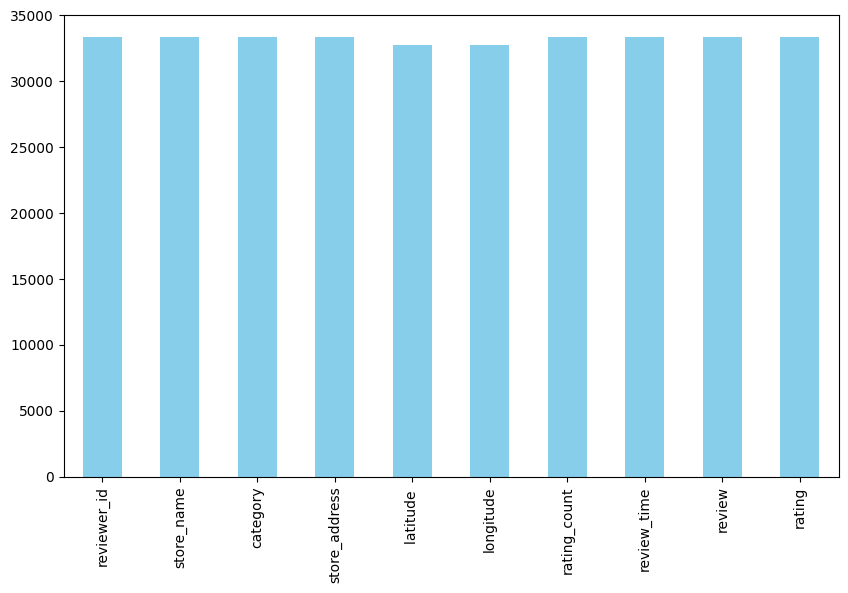

In [489]:
#Crear el gráfico de barras
plt.figure(figsize=(10, 6)) # Define el tamaño del gráfico
non_null_counts.plot(kind='bar', color='skyblue') # Usa el método de plot de Pandas#

In [490]:
#Eliminar filas con valores nulos en 'review' y 'rating'
df.dropna(subset=['review', 'rating'], inplace=True)
df['rating'] = df['rating'].astype(str).str.extract('(\\d)').astype(float)
df.dropna(subset=['rating'], inplace=True)
print("\nFilas con valores nulos eliminadas.")



Filas con valores nulos eliminadas.


In [491]:
# Clasificación de sentimientos
df['sentiment'] = df['rating'].apply(lambda x: 'positivo' if x >= 4 else ('neutral' if x == 3 else 'negativo'))


In [492]:
# Definir las variables X e y
X = df['review'].values
y = df['sentiment'].values
print("\nDatos listos para el preprocesamiento.")



Datos listos para el preprocesamiento.


In [493]:
# División de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Preprocesamiento de texto para Deep Learning

In [494]:
MAX_FEATS = 15000  # Número de palabras más comunes a considerar


In [495]:
# Tokenización de texto
tokenizer = Tokenizer(num_words=MAX_FEATS)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train) # Convertir texto a secuencias de números
X_test_sequences = tokenizer.texts_to_sequences(X_test)



In [496]:
# Padding de  secuencias con la misma longitud
max_sequence_len = max([len(x) for x in X_train_sequences])
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_len, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_len, padding='post')



In [497]:
# Conversión de etiquetas a formato binario
lb = LabelBinarizer()
y_train_encoded = lb.fit_transform(y_train)
y_test_encoded = lb.transform(y_test)
num_classes = len(lb.classes_)

modelo de Deep Learning (LSTM)

In [498]:
model = Sequential()
model.add(Embedding(input_dim=MAX_FEATS + 1, output_dim=128, input_length=max_sequence_len)) ## Capa de Embedding: Mapea los índices de enteros a vectores densos.
model.add(LSTM(128)) # Capa LSTM: Captura dependencias a largo plazo en secuencias.
model.add(Dropout(0.5)) # Capa Dropout: Previene el sobreajuste.
model.add(Dense(64, activation='relu')) # capa oculta con 64 neuronas
model.add(Dense(32, activation='relu')) # capa oculta con 32 neuronas
model.add(Dense(num_classes, activation='softmax')) # capa de salida

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [499]:
#Entrenar el modelo
model.fit(X_train_padded, y_train_encoded,
          epochs=10,
          batch_size=32,
          validation_data=(X_test_padded, y_test_encoded),
          verbose=1)


Epoch 1/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 127s 151ms/step - accuracy: 0.4804 - loss: 1.0062 - val_accuracy: 0.4787 - val_loss: 0.9967
Epoch 2/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 127s 152ms/step - accuracy: 0.4815 - loss: 1.0021 - val_accuracy: 0.4787 - val_loss: 0.9972
Epoch 3/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 127s 152ms/step - accuracy: 0.4815 - loss: 1.0014 - val_accuracy: 0.4787 - val_loss: 0.9975
Epoch 4/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 128s 153ms/step - accuracy: 0.4815 - loss: 1.0004 - val_accuracy: 0.4787 - val_loss: 1.0044
Epoch 5/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 127s 152ms/step - accuracy: 0.4815 - loss: 1.0010 - val_accuracy: 0.4787 - val_loss: 0.9961
Epoch 6/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 125s 150ms/step - accuracy: 0.4815 - loss: 1.0007 - val_accuracy: 0.4787 - val_loss: 0.9962
Epoch 7/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 126s 151ms/step - accuracy: 0.4815 - loss: 1.0005 - val_accuracy: 0.4787 - val_loss: 0.9973
Epoch 8/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 126s 151ms/step - accuracy: 0.4815 -

In [500]:
#Evaluar el modelo ---
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded, verbose=0)
print(f"\nPrecisión en el conjunto de prueba: {accuracy:.4f}")


Precisión en el conjunto de prueba: 0.4787


In [502]:
#Ejemplo de predicción
new_review_es = "La comida fue excelente, el servicio muy malo."
translator = GoogleTranslator(source='spanish', target='english')
new_review_en = translator.translate(new_review_es)

print(f"Reseña original en español: '{new_review_es}'")
print(f"Reseña traducida al inglés: '{new_review_en}'")
new_review_seq = tokenizer.texts_to_sequences([new_review])
new_review_padded = pad_sequences(new_review_seq, maxlen=max_sequence_len, padding='post')
prediction = model.predict(new_review_padded)
predicted_sentiment = lb.inverse_transform(prediction)
print(f"\nLa reseña: '{new_review}'")
print(f"Predicción del sentimiento: {predicted_sentiment[0]}")

Reseña original en español: 'La comida fue excelente, el servicio muy malo.'
Reseña traducida al inglés: 'The food was excellent, the very bad service.'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

La reseña: 'La comida fue excelente, el servicio terrible.'
Predicción del sentimiento: positivo
